Group Project Report : Heart Disease
-

Introduction:
As of 2020, heart disease was one of the most leading factors contributing to death worldwide. The most common cause of heart disease is a buildup of fatty plaques in the arteries. Risk factors for heart disease include a poor diet, lack of exercise, obesity, and smoking. Symptoms of heart disease include rapid heart rate, chest pain, and shortness of breath. Gaining an acuurate and useful diagnosis from a doctor can be quite tedious and time consuming. A digital classifier could help speed up the process of diagnosis and decrease possible risks to health. 

The question we will be adressing is; How do x and y affect the likelyhood of posessing heart disease ? 

The data set that will be used is "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data" and it contains 14 attributes which state the quantitative variables that are of interest in regard to heart disease factors: 
- 1. age: age in years
- 2. sex: sex (1 = male; 0 = female)
- 3. cp: chest pain type 
- 4. trestbps: resting blood pressure (in mm Hg)
- 5. chol: serum cholestoral in mg/dl
- 6. fbs: (fasting blood sugar > 120 mg/dl)
- 7. restecg: resting electrocardiographic results
- 8. thalach: maximum heart rate achieved
- 9. exang: exercise induced angina
- 10. oldpeak = ST depression induced by exercise relative to rest
- 11. slope: the slope of the peak exercise ST segment
- 12. ca: number of major vessels (0-3) colored by flourosopy
- 13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
- 14. num: diagnosis of heart disease (angiographic disease status)

Methods and Results 
-

Describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
Your report should include code which:
- loads data from the original source on the web 
- wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
- performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
- creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
- performs the data analysis
- creates a visualization of the analysis 

note: all tables and figure should have a figure/table number and a legend

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
#First we need to load the data into r and remove and
# any empty cells. We also need to assign column names to
# the data
heart_disease <- read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names = FALSE) |>
                    rename(age =X1,
                              sex = X2,
                              cp = X3,
                              trestbps = X4,
                              chol = X5,
                              fbs = X6,
                              restecg = X7,
                              thalach = X8, 
                              exang = X9,
                              oldpeak = X10, 
                              slope = X11, 
                              ca = X12, 
                              thal = X13, 
                              num = X14) |>
                    mutate(num = as_factor(num)) 
#we still have to figure out how to remove the ? from the data, probably have to ask the TA.
heart_disease<- heart_disease %>%
mutate(num_edited = ifelse(num == 0, "No", ifelse(num == 1 | num == 2 | num == 3 | num == 4 , "Yes", NA)))
heart_disease

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,num_edited
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<chr>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0,No
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2,Yes
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1,Yes
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3,Yes
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1,Yes
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0,No


In [3]:
#summary of the data set 
# makes num the factor by which every predictor is being used to classify
heart_disease <- heart_disease |> 
    mutate(heart_disease_presence = as_factor(num_edited))

#shows the different categories that heart disease can be classified as
heart_disease |>
    pull(heart_disease_presence) |>
    levels()

#Show the percentage of the whole data that each level of severity makes up
num_obs <- nrow(heart_disease)
heart_disease |> 
    group_by(heart_disease_presence) |> 
    summarize(
        count = n(),
        percentage = n() / num_obs * 100
        )

[1] "No"  "Yes"

heart_disease_presence,count,percentage
<fct>,<int>,<dbl>
No,164,54.12541
Yes,139,45.87459


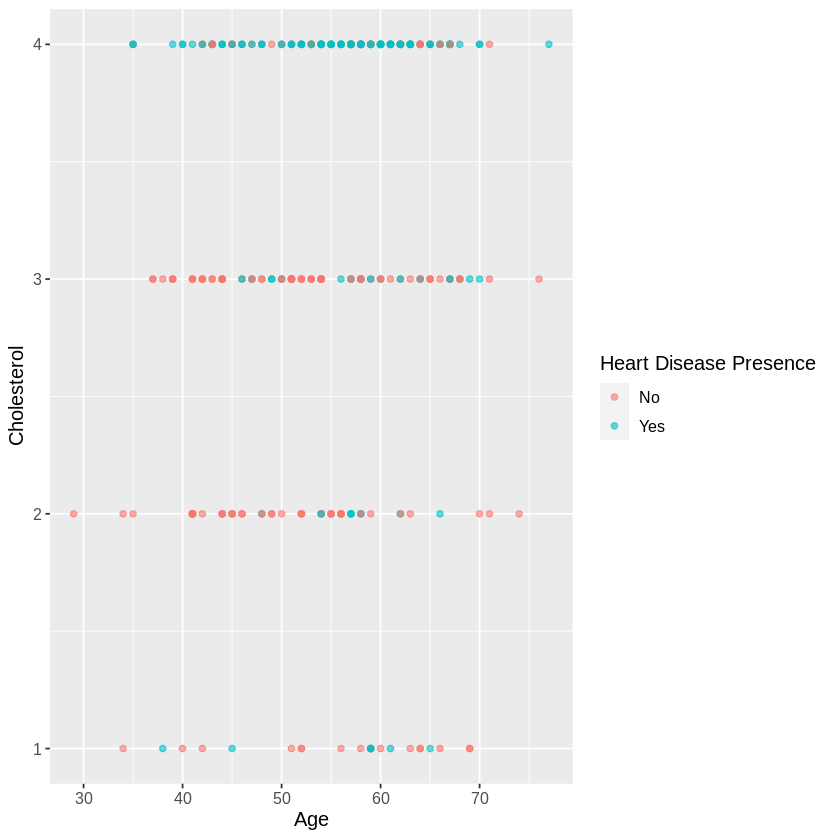

In [4]:
#visualization of the 2 predictors and where each category
# of classified data falls into
age_chol <- heart_disease |> 
    ggplot(aes(x = age, y = , color = num_edited)) +
    geom_point(alpha = 0.6) +
    labs(x = "Age",
         y = "Cholesterol",
         color = "Heart Disease Presence") +
    theme(text = element_text(size =12))
age_chol

Disscussion
-

summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

Refrences 
-
- At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references). (MLA Formatting)
    - “Cardiovascular Diseases (Cvds).” World Health Organization, World Health Organization, https://www.who.int/news-room/fact-sheets/detail/cardiovascular-diseases-(cvds). Acessed 23. Nov. 2022
    - Virani, Salim S., et al. “Heart Disease and Stroke Statistics-2021 Update.” Circulation, 27 Jan. 2021, https://www.ahajournals.org/doi/10.1161/CIR.0000000000000950. Acessed 19. Nov. 2022
- Make sure to cite the source of your data as well.
    - UCI Machine Learning Repository: Heart Disease Data Set, https://archive.ics.uci.edu/ml/datasets/Heart%20Disease. Acessed 20. Oct. 2022